![](../img/330-banner.png)

# Lecture 8: Hyperparameter Optimization and Optimization Bias

UBC 2025-26

## Imports and LO

### Imports

In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(".."), "code"))

import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)
DATA_DIR = "../data/"

In [2]:
from sklearn import set_config

set_config(display="diagram")

<br><br>

### Learning outcomes 

From this lecture, you will be able to 

- explain the need for hyperparameter optimization  
- carry out hyperparameter optimization using `sklearn`'s `GridSearchCV` and `RandomizedSearchCV` 
- explain different hyperparameters of `GridSearchCV`
- explain the importance of selecting a good range for the values. 
- explain optimization bias
- identify and reason when to trust and not trust reported accuracies 

<br><br><br><br>

## Hyperparameter optimization motivation [(video)](https://www.youtube.com/watch?v=lMWdHZSZMk8)

### Motivation

- Remember that the **fundamental goal** of supervised machine learning is to **generalize** beyond what we see in the training examples. 
- We have been using data splitting and cross-validation to provide a framework to **approximate generalization error**.  
- With this framework, we can improve the model's generalization performance by ***tuning model hyperparameters*** using cross-validation on the training set. 

### Hyperparameters: the problem

- In order to improve the generalization performance, finding the best values for the important hyperparameters of a model is necessary for almost all models and datasets. 
- Picking **good hyperparameters** is important because if we don't do it, we might end up with an **underfit** or **overfit** model. 

### Some ways to pick hyperparameters:
- **Manual** or expert knowledge or heuristics based optimization 
- Data-driven or **automated** optimization

#### Manual hyperparameter optimization

- Advantage: we may have some intuition about what might work.
  - E.g. if I'm massively overfitting, try decreasing `max_depth` or `C`.
- Disadvantages
    - it takes a lot of work
    - not reproducible
    - in very complicated cases, our intuition might be worse than a data-driven approach

### Automated hyperparameter optimization 

- Formulate the hyperparamter optimization as a **one big search problem**.
- Often we have many hyperparameters of different types: Categorical, integer, and continuous.
- Often, the search space is quite big and systematic search for optimal values is infeasible. 

In homework assignments, we have been carrying out hyperparameter search by exhaustively trying different possible combinations of the hyperparameters of interest. 

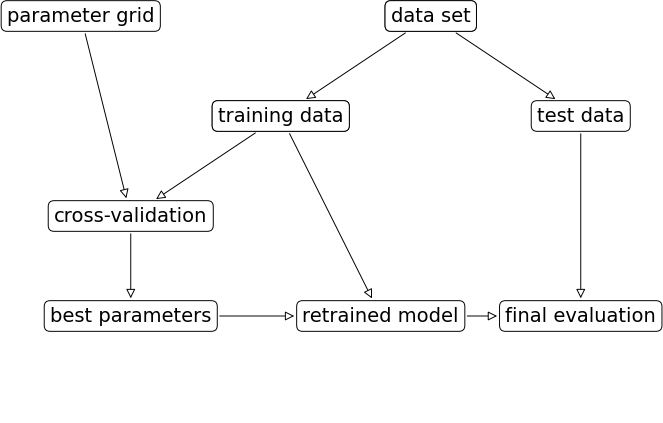

In [3]:
mglearn.plots.plot_grid_search_overview()

Let's look at an example of tuning `max_depth` of the `DecisionTreeClassifier` on the Spotify dataset. 

In [4]:
spotify_df = pd.read_csv(DATA_DIR + "spotify.csv", index_col=0)
X_spotify = spotify_df.drop(columns=["target", "artist"])
y_spotify = spotify_df["target"]
X_spotify.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,Mask Off
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,Redbone
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,Xanny Family
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,Master Of None
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,Parallel Lines


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_spotify, y_spotify, test_size=0.2, random_state=123
)

In [6]:
numeric_feats = ['acousticness', 'danceability', 'energy',
                 'instrumentalness', 'liveness', 'loudness',
                 'speechiness', 'tempo', 'valence']
categorical_feats = ['time_signature', 'key']
passthrough_feats = ['mode']
text_feat = "song_title"

In [7]:
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_feats), 
    (OneHotEncoder(handle_unknown = "ignore"), categorical_feats), 
    ("passthrough", passthrough_feats), 
    (CountVectorizer(max_features=100, stop_words="english"), text_feat)
)

svc_pipe = make_pipeline(preprocessor, SVC)

In [8]:
best_score = 0

param_grid = {"max_depth": np.arange(1, 20, 2)}

results_dict = {"max_depth": [], "mean_cv_score": []}

for depth in param_grid[
    "max_depth"
]:  # for each combination of parameters, train an SVC
    dt_pipe = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=depth))
    scores = cross_val_score(dt_pipe, X_train, y_train)  # perform cross-validation
    mean_score = np.mean(scores)  # compute mean cross-validation accuracy
    if (
        mean_score > best_score
    ):  # if we got a better score, store the score and parameters
        best_score = mean_score
        best_params = {"max_depth": depth}
    results_dict["max_depth"].append(depth)
    results_dict["mean_cv_score"].append(mean_score)

In [9]:
best_params

{'max_depth': np.int64(5)}

In [10]:
best_score

np.float64(0.7315558717766282)

Let's try SVM RBF and tuning `C` and `gamma` on the same dataset. 

In [11]:
pipe_svm = make_pipeline(preprocessor, SVC())  # We need scaling for SVM RBF
pipe_svm.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('svc', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('standardscaler', ...), ('onehotencoder', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

Let's try cross-validation with default hyperparameters of SVC. 

In [12]:
scores = cross_validate(pipe_svm, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       0.110864
score_time     0.032775
test_score     0.733394
train_score    0.828891
dtype: float64

Now let's try **exhaustive hyperparameter search** using for loops. 

This is what we have been doing for this:

```python
for gamma in [0.01, 1, 10, 100]: # for some values of gamma
    for C in [0.01, 1, 10, 100]: # for some values of C
        for fold in folds:
            fit in training portion with the given C
            score on validation portion
        compute average score
        
pick hyperparameter values which yield with best average score
```

In [13]:
best_score = 0

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1, 10, 100],
}

results_dict = {"C": [], "gamma": [], "mean_cv_score": []}

for gamma in param_grid["gamma"]:
    for C in param_grid["C"]:  # for each combination of parameters, train an SVC
        pipe_svm = make_pipeline(preprocessor, SVC(gamma=gamma, C=C))
        scores = cross_val_score(pipe_svm, X_train, y_train)  # perform cross-validation
        mean_score = np.mean(scores)  # compute mean cross-validation accuracy
        if (
            mean_score > best_score
        ):  # if we got a better score, store the score and parameters
            best_score = mean_score
            best_parameters = {"C": C, "gamma": gamma}
        results_dict["C"].append(C)
        results_dict["gamma"].append(gamma)
        results_dict["mean_cv_score"].append(mean_score)

In [14]:
best_parameters

{'C': 1, 'gamma': 0.1}

In [15]:
best_score

np.float64(0.7371228582966367)

In [16]:
df = pd.DataFrame(results_dict)

In [17]:
df.sort_values(by="mean_cv_score", ascending=False).head(10)

,C,gamma,mean_cv_score
15,1.0,0.100,0.737123
16,10.0,0.100,0.721003
11,100.0,0.010,0.720368
10,10.0,0.010,0.718514
5,100.0,0.001,0.705519
14,0.1,0.100,0.701792
9,1.0,0.010,0.691258
4,10.0,0.001,0.675761
17,100.0,0.100,0.673880
8,0.1,0.010,0.652207


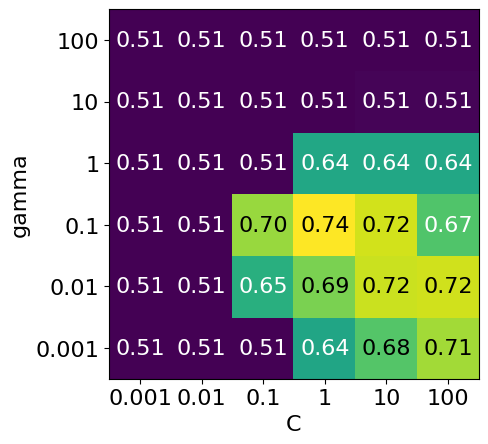

In [18]:
scores = np.array(df.mean_cv_score).reshape(6, 6)

my_heatmap(
    scores,
    xlabel="C",
    xticklabels=param_grid["C"],
    ylabel="gamma",
    yticklabels=param_grid["gamma"],
    cmap="viridis",
    fmt="%0.2f"
);
# plot the mean cross-validation scores

- We have 6 possible values for `C` and 6 possible values for `gamma`. 
- In 5-fold cross-validation, for each combination of parameter values, five accuracies are computed.
- So to evaluate the accuracy of the SVM using 6 values of `C` and 6 values of `gamma` using five-fold cross-validation, we need to train 36 * 5 = 180 models! 

In [19]:
param_grid

{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [20]:
np.prod(list(map(len, param_grid.values())))

np.int64(36)

Or, using Python's list comprehension:

In [21]:
np.prod([len(v) for v in param_grid.values()])

np.int64(36)

Once we have optimized hyperparameters, we retrain a model on the full training set with these optimized hyperparameters. 

In [22]:
best_parameters

{'C': 1, 'gamma': 0.1}

In [23]:
pipe_svm = make_pipeline(preprocessor, SVC(**best_parameters))
pipe_svm.fit(
    X_train, y_train
)  # Retrain a model with optimized hyperparameters on the combined training and validation set

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('svc', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('standardscaler', ...), ('onehotencoder', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

___
In Python, the double asterisk (`**`) followed by a variable name is used to pass a variable number of keyword arguments to a function. This allows to pass a dictionary of named arguments to a function, where keys of the dictionary become the argument names and values become the corresponding argument values.

**TIP**: Optionally, see the __Python Side Note__ on *unpacking* at the end of the notes below.
___

And finally evaluate the performance of this model on the test set. 

In [24]:
pipe_svm.score(X_test, y_test)  # Final evaluation on the test data

0.7475247524752475

This process is so common that there are some **standard methods** in `scikit-learn` where we can carry out all of this in a more compact way. 

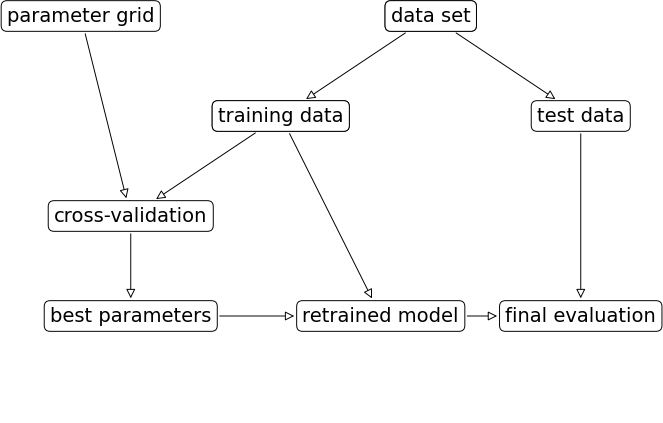

In [25]:
mglearn.plots.plot_grid_search_overview()

In this lecture we are going to talk about two such most commonly used **automated optimizations methods** from `scikit-learn`. 

- Exhaustive grid search: [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- Randomized search: [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

The `CV` stands for cross-validation; these methods have built-in cross-validation.

<br><br><br><br>

## Exhaustive grid search: [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

- For `GridSearchCV` we need
    - an instantiated model or a pipeline
    - a parameter grid: A user specifies a set of values for each hyperparameter. 
    - other optional arguments 

The method considers product of the sets and evaluates each combination one by one.    

In [26]:
from sklearn.model_selection import GridSearchCV

pipe_svm = make_pipeline(preprocessor, SVC())

param_grid = {
    "columntransformer__countvectorizer__max_features": [100, 200, 400, 800, 1000, 2000],
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

# Create a grid search object 
gs = GridSearchCV(pipe_svm, 
                  param_grid = param_grid, 
                  n_jobs=-1, 
                  return_train_score=True
                 )

The `GridSearchCV` object above behaves like a classifier. We can call `fit`, `predict` or `score` on it. 

In [27]:
# Carry out the search 
gs.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...svc', SVC())])"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'columntransformer__countvectorizer__max_features': [100, 200, ...], 'svc__C': [0.001, 0.01, ...], 'svc__gamma': [0.001, 0.01, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fol

Fitting the `GridSearchCV` object 
- Searches for the best hyperparameter values
- You can access the best score and the best hyperparameters using `best_score_` and `best_params_` attributes, respectively. 

In [28]:
# Get the best score
gs.best_score_

np.float64(0.7402188335288348)

In [29]:
# Get the best hyperparameter values
gs.best_params_

{'columntransformer__countvectorizer__max_features': 800,
 'svc__C': 1.0,
 'svc__gamma': 0.1}

- It is often helpful to visualize results of all cross-validation experiments. 
- You can access this information using `cv_results_` attribute of a fitted `GridSearchCV` object.  

In [30]:
pd.DataFrame(param_grid)

,columntransformer__countvectorizer__max_features,svc__gamma,svc__C
0,100,0.001,0.001
1,200,0.010,0.010
2,400,0.100,0.100
3,800,1.000,1.000
4,1000,10.000,10.000
5,2000,100.000,100.000


In [31]:
np.prod(list(map(len, param_grid.values())))

np.int64(216)

In [32]:
results = pd.DataFrame(gs.cv_results_)
results.T

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
mean_fit_time,0.239648,0.243785,0.252506,0.264486,0.243411,0.311624,0.21558,0.217421,0.218061,0.225739,...,0.354959,0.32492,0.337219,0.459745,0.273812,0.380633,0.316312,0.30477,0.302582,0.336776
std_fit_time,0.010995,0.010123,0.009651,0.009513,0.031174,0.011175,0.007712,0.005783,0.005647,0.016409,...,0.01654,0.014784,0.015994,0.020773,0.006213,0.015003,0.016302,0.012869,0.006458,0.022407
mean_score_time,0.058612,0.063068,0.068264,0.068528,0.063559,0.095315,0.063033,0.062175,0.067959,0.060547,...,0.064339,0.075022,0.0759,0.108155,0.056755,0.056144,0.058914,0.071573,0.063375,0.065755
std_score_time,0.001478,0.005007,0.006661,0.004743,0.004291,0.012651,0.006307,0.004824,0.005462,0.006724,...,0.004351,0.00446,0.002183,0.011079,0.003594,0.003271,0.00382,0.007656,0.00568,0.005474
param_columntransformer__countvectorizer__max_features,100,100,100,100,100,100,100,100,100,100,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
param_svc__C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,10.0,10.0,10.0,10.0,100.0,100.0,100.0,100.0,100.0,100.0
param_svc__gamma,0.001,0.01,0.1,1.0,10.0,100.0,0.001,0.01,0.1,1.0,...,0.1,1.0,10.0,100.0,0.001,0.01,0.1,1.0,10.0,100.0
params,"{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 1.0}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 10}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.001, 'svc__gamma': 100}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.01, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.01, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.01, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 0.01, 'svc__gamma': 1.0}",...,"{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 1.0}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 10}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 100}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 1.0}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 10}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 100, 'svc__gamma': 100}"
split0_test_score,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,...,0.733746,0.616099,0.50774,0.504644,0.718266,0.718266,0.724458,0.616099,0.50774,0.504644
split1_test_score,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,...,0.77709,0.625387,0.510836,0.510836,0.724458,0.739938,0.764706,0.625387,0.510836,0.510836


In [33]:
# Let's sort the results by performance on the validation folds

results = (
    pd.DataFrame(gs.cv_results_).set_index("rank_test_score").sort_index()
)
display(results.T)

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,121,121,121,121,121,121,121,121,121,121
mean_fit_time,0.27335,0.269976,0.263974,0.190779,0.221144,0.204487,0.372806,0.317758,0.354959,0.355727,...,0.288442,0.296154,0.290642,0.295845,0.280419,0.287662,0.323518,0.280878,0.445827,0.356052
std_fit_time,0.0274,0.020828,0.020796,0.009495,0.008926,0.008003,0.00946,0.009292,0.01654,0.007639,...,0.030885,0.018179,0.02428,0.015903,0.027724,0.027259,0.02405,0.00843,0.020755,0.010843
mean_score_time,0.056995,0.059839,0.059337,0.046831,0.054765,0.050741,0.054755,0.048621,0.064339,0.060191,...,0.075626,0.073764,0.089548,0.089839,0.076776,0.074241,0.07953,0.07531,0.104307,0.082038
std_score_time,0.004242,0.005929,0.004207,0.002882,0.00299,0.004484,0.00256,0.00298,0.004351,0.005559,...,0.00655,0.003007,0.008995,0.006186,0.009701,0.008992,0.008137,0.007319,0.01207,0.009681
param_columntransformer__countvectorizer__max_features,800,2000,1000,100,400,200,1000,400,2000,800,...,1000,1000,1000,1000,1000,1000,2000,2000,2000,2000
param_svc__C,1.0,1.0,1.0,1.0,1.0,1.0,100.0,10.0,10.0,10.0,...,0.1,0.1,0.01,0.01,0.001,0.001,0.1,0.1,0.1,0.1
param_svc__gamma,0.1,0.1,0.1,0.1,0.1,0.1,0.01,0.1,0.1,0.1,...,0.001,1.0,0.01,0.001,0.001,0.01,1.0,0.001,100.0,10.0
params,"{'columntransformer__countvectorizer__max_features': 800, 'svc__C': 1.0, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 1.0, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 1.0, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 100, 'svc__C': 1.0, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 400, 'svc__C': 1.0, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 200, 'svc__C': 1.0, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 100, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 400, 'svc__C': 10, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 10, 'svc__gamma': 0.1}","{'columntransformer__countvectorizer__max_features': 800, 'svc__C': 10, 'svc__gamma': 0.1}",...,"{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 0.1, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 0.1, 'svc__gamma': 1.0}","{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 0.01, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 0.01, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 0.001, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 1000, 'svc__C': 0.001, 'svc__gamma': 0.01}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 0.1, 'svc__gamma': 1.0}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 0.1, 'svc__gamma': 0.001}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 0.1, 'svc__gamma': 100}","{'columntransformer__countvectorizer__max_features': 2000, 'svc__C': 0.1, 'svc__gamma': 10}"
split0_test_score,0.764706,0.767802,0.767802,0.767802,0.764706,0.758514,0.73065,0.74613,0.733746,0.71517,...,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774
split1_test_score,0.764706,0.770898,0.764706,0.752322,0.764706,0.752322,0.755418,0.780186,0.77709,0.783282,...,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774


Let's only look at the most relevant ones: 

In [34]:
relevant = [
    "mean_test_score",
    "param_columntransformer__countvectorizer__max_features", 
    "param_svc__gamma",
    "param_svc__C",
    "mean_fit_time",
    "rank_test_score",
]

In [35]:
pd.DataFrame(gs.cv_results_)[relevant].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,121,121,121,121,121,121,121,121,121,121
mean_test_score,0.740219,0.738977,0.738357,0.737123,0.737119,0.734023,0.729071,0.727814,0.726583,0.725349,...,0.507750,0.507750,0.507750,0.507750,0.507750,0.507750,0.507750,0.507750,0.507750,0.507750
param_columntransformer__countvectorizer__max_features,800.000000,2000.000000,1000.000000,100.000000,400.000000,200.000000,1000.000000,400.000000,2000.000000,800.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,2000.000000,2000.000000,2000.000000,2000.000000
param_svc__gamma,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.010000,0.100000,0.100000,0.100000,...,0.001000,1.000000,0.010000,0.001000,0.001000,0.010000,1.000000,0.001000,100.000000,10.000000
param_svc__C,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,10.000000,10.000000,10.000000,...,0.100000,0.100000,0.010000,0.010000,0.001000,0.001000,0.100000,0.100000,0.100000,0.100000
mean_fit_time,0.273350,0.269976,0.263974,0.190779,0.221144,0.204487,0.372806,0.317758,0.354959,0.355727,...,0.288442,0.296154,0.290642,0.295845,0.280419,0.287662,0.323518,0.280878,0.445827,0.356052


- Other than searching for best hyperparameter values, `GridSearchCV` also **fits a new model** on the whole training set with the parameters that yielded the **best results**.
- So we can conveniently call `score` on the test set with a fitted `GridSearchCV` object. 

In [36]:
# Get the test scores 

gs.score(X_test, y_test)

0.7574257425742574

Why are `best_score_` and the score above different? 

### `n_jobs=-1`
- Note the `n_jobs=-1` above.
- Hyperparameter optimization can be done _in parallel_ for each of the configurations.
- This is very useful when scaling up to large numbers of machines in the cloud.
- When you set `n_jobs=-1`, it means that you want to use all available CPU cores for the task. 

### The `__` syntax

- Above: we have a nesting of transformers.
- We can access the parameters of the "inner" objects by using `__` to go "deeper":
- `svc__gamma`: the `gamma` of the `svc` of the pipeline
- `svc__C`: the `C` of the `svc` of the pipeline
- `columntransformer__countvectorizer__max_features`: the `max_features` hyperparameter of `CountVectorizer` in the column transformer `preprocessor`. 

In [37]:
pipe_svm

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('svc', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('standardscaler', ...), ('onehotencoder', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

### Range of `C`

- Note the exponential range for `C`. This is quite common. Using this exponential range allows you to explore a wide range of values efficiently.
- There is no point trying $C=\{1,2,3\ldots,100\}$ because $C=1,2,3$ are too similar to each other.
- Often we're trying to find an order of magnitude, e.g. $C=\{0.01,0.1,1,10,100\}$. 
- We can also write that as $C=\{10^{-2},10^{-1},10^0,10^1,10^2\}$. 
- Or, in other words, $C$ values to try are $10^n$ for $n=-2,-1,0,1,2$ which is basically what we have above.

<br><br>

### Visualizing the parameter grid as a heatmap 

In [38]:
def display_heatmap(param_grid, pipe, X_train, y_train):
    grid_search = GridSearchCV(
        pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    results = pd.DataFrame(grid_search.cv_results_)
    scores = np.array(results.mean_test_score).reshape(6, 6)

    # plot the mean cross-validation scores
    my_heatmap(
        scores,
        xlabel="gamma",
        xticklabels=param_grid["svc__gamma"],
        ylabel="C",
        yticklabels=param_grid["svc__C"],
        cmap="viridis",
    );

- Note that the range we pick for the parameters plays an important role in hyperparameter optimization. 
- For example, consider the following grid and the corresponding results.  

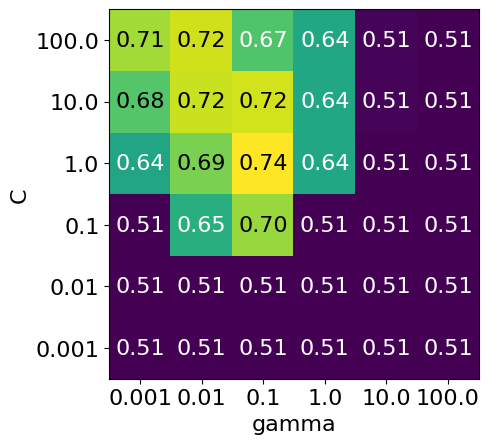

In [39]:
param_grid1 = {
    "svc__gamma": 10.0**np.arange(-3, 3, 1), 
    "svc__C": 10.0**np.arange(-3, 3, 1)
}
display_heatmap(param_grid1, pipe_svm, X_train, y_train)

- Each point in the heat map corresponds to one run of cross-validation, with a particular setting
- Colour encodes cross-validation accuracy. 
    - Lighter colour means high accuracy
    - Darker colour means low accuracy
- SVC is quite sensitive to hyperparameter settings.
- Adjusting hyperparameters can change the accuracy from 0.51 to 0.74! 

<br><br>

### Bad range for hyperparameters 

In [40]:
np.logspace(1, 2, 6)

array([ 10.        ,  15.84893192,  25.11886432,  39.81071706,
        63.09573445, 100.        ])

In [41]:
np.linspace(1, 2, 6)

array([1. , 1.2, 1.4, 1.6, 1.8, 2. ])

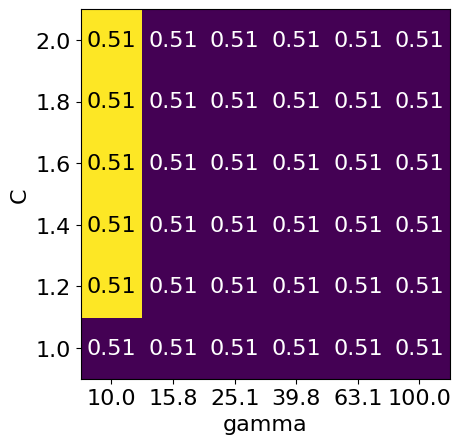

In [42]:
param_grid2 = {"svc__gamma": np.round(np.logspace(1, 2, 6), 1), "svc__C": np.linspace(1, 2, 6)}
display_heatmap(param_grid2, pipe_svm, X_train, y_train)

### Different range for hyperparameters yields better results! 

In [43]:
np.logspace(-3, 2, 6)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [44]:
np.linspace(1, 10, 6)

array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. ])

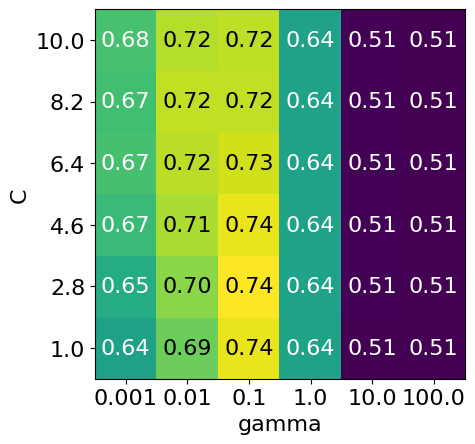

In [45]:
param_grid3 = {"svc__gamma": np.logspace(-3, 2, 6), "svc__C": np.linspace(1, 10, 6)}

display_heatmap(param_grid3, pipe_svm, X_train, y_train)

It seems like we are getting better cross-validation results with `C` around 2.8 and `gamma` = 0.1 

How about exploring different values of `C` around 3?

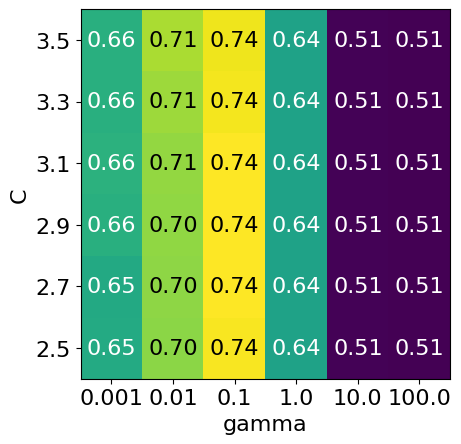

In [46]:
param_grid4 = {"svc__gamma": np.logspace(-3, 2, 6), "svc__C": np.linspace(2.5, 3.5, 6)}

display_heatmap(param_grid4, pipe_svm, X_train, y_train)

That's good! We are finding some more options for `C` where the accuracy is 0.75. 
The tricky part is we do not know in advance what range of hyperparameters might work the best for the given problem, model, and the dataset.    

Next, I could try to test more values of `gamma` around 0.1.

___
`GridSearchCV` allows the param_grid to be a list of dictionaries. Sometimes some hyperparameters are applicable only for certain models. 
For example, in the context of `SVC`, `C` and `gamma` are applicable when the kernel is `rbf` whereas only `C` is applicable for `kernel="linear"`.    
___

### Problems with exhaustive grid search 

- Required number of models to evaluate grows **exponentially with the dimensionality** of the configuration space. 
- Example: Suppose you have
    - 5 hyperparameters 
    - 10 different values for each hyperparameter
    - You'll be evaluating $10^5=100,000$ models! That is you'll be calling `cross_validate` $100,000$ times!
- Exhaustive search may become **infeasible fairly quickly**.
- Other options?

<br><br><br><br>

## Randomized hyperparameter search

- Randomized hyperparameter optimization 
    - [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
- Samples configurations at **random until certain budget** (e.g., time) is exhausted 

In [47]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "columntransformer__countvectorizer__max_features": [100, 200, 400, 800, 1000, 2000],
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": [0.001, 0.01, 0.1, 1.0, 10, 100]
}

print("Grid size: %d" % (np.prod(list(map(len, param_grid.values())))))
param_grid

Grid size: 216


{'columntransformer__countvectorizer__max_features': [100,
  200,
  400,
  800,
  1000,
  2000],
 'svc__gamma': [0.001, 0.01, 0.1, 1.0, 10, 100],
 'svc__C': [0.001, 0.01, 0.1, 1.0, 10, 100]}

In [48]:
# Create a random search object
random_search = RandomizedSearchCV(pipe_svm,                                    
                  param_distributions = param_grid, 
                  n_iter=100, 
                  n_jobs=-1, 
                  return_train_score=True)

# Carry out the search
random_search.fit(X_train, y_train)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...svc', SVC())])"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'columntransformer__countvectorizer__max_features': [100, 200, ...], 'svc__C': [0.001, 0.01, ...], 'svc__gamma': [0.001, 0.01, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",100
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.

In [49]:
relevant

['mean_test_score',
 'param_columntransformer__countvectorizer__max_features',
 'param_svc__gamma',
 'param_svc__C',
 'mean_fit_time',
 'rank_test_score']

In [50]:
pd.DataFrame(random_search.cv_results_)[relevant].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,60,60,60,60,60,60,60,60,60,60
mean_test_score,0.740219,0.738357,0.737123,0.734023,0.727814,0.726583,0.724724,0.723493,0.721008,0.720401,...,0.507750,0.507750,0.50775,0.507750,0.507750,0.507750,0.507750,0.507750,0.507750,0.507750
param_columntransformer__countvectorizer__max_features,800.000000,1000.000000,100.000000,200.000000,400.000000,2000.000000,800.000000,1000.000000,2000.000000,200.000000,...,800.000000,100.000000,1000.00000,100.000000,400.000000,2000.000000,200.000000,200.000000,1000.000000,200.000000
param_svc__gamma,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.010000,0.100000,0.010000,0.100000,...,0.010000,0.001000,0.01000,0.100000,0.100000,100.000000,10.000000,100.000000,10.000000,0.100000
param_svc__C,1.000000,1.000000,1.000000,1.000000,10.000000,10.000000,100.000000,10.000000,10.000000,10.000000,...,0.001000,0.001000,0.00100,0.010000,0.010000,0.100000,0.100000,0.100000,0.001000,0.010000
mean_fit_time,0.229178,0.246249,0.203189,0.225987,0.336910,0.323196,0.337081,0.347138,0.249603,0.287675,...,0.252064,0.240244,0.25831,0.235419,0.228437,0.429167,0.252011,0.354007,0.261873,0.222536


### `n_iter`

- Note the `n_iter`, we didn't need this for `GridSearchCV`.
- Larger `n_iter` will take longer but it'll do more searching.
  - Remember you still need to multiply by number of folds!
- I have set the `random_state` for reproducibility but you don't have to do it.

### Passing probability distributions to random search

Another thing we can do is give probability distributions to draw from:

In [51]:
from scipy.stats import expon, lognorm, loguniform, randint, uniform, norm, randint

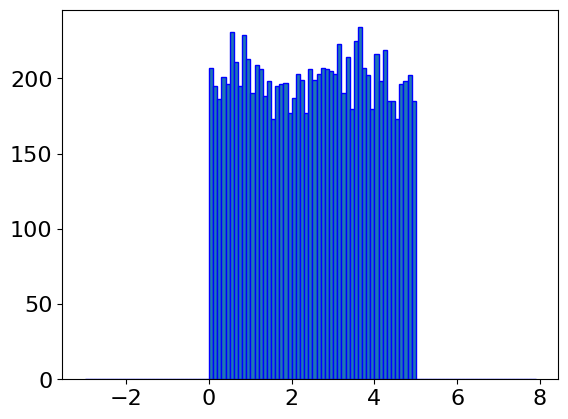

In [52]:
np.random.seed(123)

y = uniform.rvs(0, 5, 10000)
bin = np.arange(-3,8,0.1)  

plt.hist(y, bins=bin, edgecolor='blue') 
plt.show()

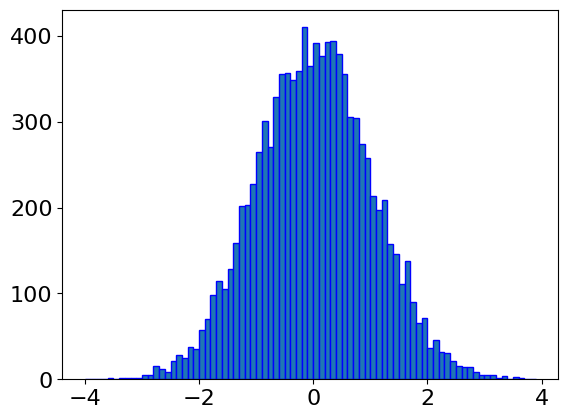

In [53]:
y = norm.rvs(0, 1, 10000)

#creating bin
bin = np.arange(-4,4,0.1)  

plt.hist(y, bins=bin, edgecolor='blue') 
plt.show()

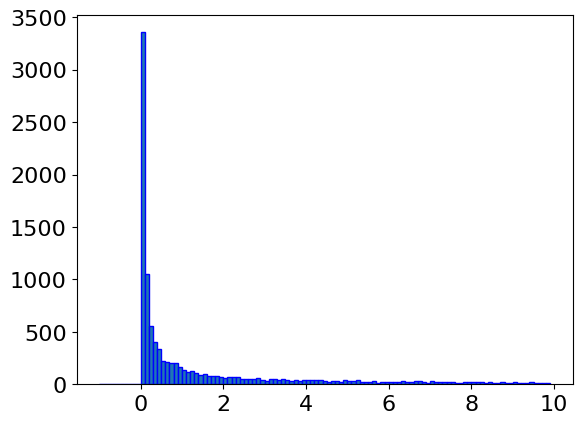

In [54]:
y = loguniform.rvs(1e-2, 1e1, size = 10000)
# y = expon.rvs(0, 1, 10000)

#creating bin
bin = np.arange(-1,10,0.1)  

plt.hist(y, bins=bin, edgecolor='blue') 
plt.show()

<br><br>

In [55]:
pipe_svm

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('svc', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('standardscaler', ...), ('onehotencoder', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

In [56]:
from scipy.stats import randint

param_dist = {
    "columntransformer__countvectorizer__max_features": randint(100, 2000), 
    "svc__C": uniform(0.1, 1e4),  # loguniform(1e-3, 1e3),
    "svc__gamma": loguniform(1e-5, 1e3),
}

In [57]:
# Create a random search object
random_search = RandomizedSearchCV(pipe_svm,                                    
                  param_distributions = param_dist, 
                  n_iter=100, 
                  n_jobs=-1, 
                  return_train_score=True)

# Carry out the search
random_search.fit(X_train, y_train)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...svc', SVC())])"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'columntransformer__countvectorizer__max_features': <scipy.stats....x7f491e619220>, 'svc__C': <scipy.stats....x7f491e7f1070>, 'svc__gamma': <scipy.stats....x7f491e77c2f0>}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",100
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-valid

In [58]:
random_search.best_score_

np.float64(0.7278214718381631)

In [59]:
relevant

['mean_test_score',
 'param_columntransformer__countvectorizer__max_features',
 'param_svc__gamma',
 'param_svc__C',
 'mean_fit_time',
 'rank_test_score']

In [60]:
pd.DataFrame(random_search.cv_results_)[relevant].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,76,76,76,94,94,94,94,94,94,94
mean_test_score,0.727821,0.721006,0.720376,0.712336,0.710469,0.710457,0.709880,0.709874,0.708592,0.706782,...,0.508371,0.508371,0.508371,0.507130,0.507130,0.507130,0.507130,0.507130,0.507130,0.507130
param_columntransformer__countvectorizer__max_features,1619.000000,1880.000000,1014.000000,987.000000,386.000000,103.000000,1997.000000,1963.000000,246.000000,1842.000000,...,1988.000000,193.000000,616.000000,1854.000000,1562.000000,776.000000,708.000000,1631.000000,1397.000000,1715.000000
param_svc__gamma,0.123539,0.101688,0.165811,0.000508,0.000917,0.001737,0.032324,0.000503,0.391845,0.030626,...,25.789949,35.203231,192.476095,601.401895,358.257024,268.760262,984.435792,461.301200,387.490568,845.206099
param_svc__C,7551.390429,2806.696859,477.418069,559.066944,3590.674490,6728.324494,7951.972198,1520.347523,8368.005553,9300.077007,...,4145.416399,931.881166,8785.835416,1564.825306,1813.530052,7736.150115,2192.718242,389.888811,2144.534114,2451.353961
mean_fit_time,0.290227,0.351178,0.300577,0.271794,0.527307,1.134344,0.378827,0.384278,0.246213,0.368254,...,0.350555,0.362143,0.361145,0.398791,0.374861,0.409440,0.368701,0.383508,0.409749,0.437228



### Advantages of `RandomizedSearchCV`

- Faster compared to `GridSearchCV`.
- Adding parameters that do not influence the performance does not affect efficiency.
- Works better when some parameters are more important than others. 
- In general, I recommend using `RandomizedSearchCV` rather than `GridSearchCV`.    

### Advantages of `RandomizedSearchCV`

![](../img/randomsearch_bergstra.png)
    
Source: [Bergstra and Bengio, Random Search for Hyper-Parameter Optimization, JMLR 2012](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).

- The yellow on the left shows how your scores are going to change when you vary the unimportant hyperparameter.
- The green on the top shows how your scores are  going to change when you vary the important hyperparameter.
- You don't know in advance which hyperparameters are important for your problem.
- In the left figure, 6 of the 9 searches are useless because they are only varying the unimportant parameter.
- In the right figure, all 9 searches are useful.

### (Optional) Searching for optimal parameters with successive halving¶

- Successive halving is an iterative selection process where all candidates (the parameter combinations) are evaluated with a small amount of resources (e.g., small amount of training data) at the first iteration.
- Checkout [successive halving with grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) and [random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html).

In [61]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

In [62]:
rsh = HalvingRandomSearchCV(
    estimator=pipe_svm, param_distributions=param_dist, factor=2, random_state=123
)
rsh.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...svc', SVC())])"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'columntransformer__countvectorizer__max_features': <scipy.stats....x7f491e619220>, 'svc__C': <scipy.stats....x7f491e7f1070>, 'svc__gamma': <scipy.stats....x7f491e77c2f0>}"
,"n_candidates n_candidates: ""exhaust"" or int, default=""exhaust""The number of candidate parameters to sample, at the firstiteration. Using 'exhaust' will sample enough candidates so that thelast iteration uses as many resources as possible, based on`min_resources`, `max_resources` and `factor`. In this case,`min_resources` cannot be 'exhaust'.",'exhaust'
,"factor factor: int or float, default=3The 'halving' parameter, which determines the proportion of candidatesthat are selected for each subsequent iteration. For example,``factor=3`` means that only one third of the candidates are selected.",2
,"resource resource: ``'n_samples'`` or str, default='n_samples'Defines the resource that increases with each iteration. By default,the resource is the number of samples. It can also be set to anyparameter of the base estimator that accepts positive integervalues, e.g. 'n_iterations' or 'n_estimators' for a gradientboosting estimator. In this case ``max_resources`` cannot be 'auto'and must be set explicitly.",'n_samples'
,"max_resources max_resources: int, default='auto'The maximum number of resources that any candidate is allowed to usefor a given iteration. By default, this is set ``n_samples`` when``resource='n_samples'`` (default), else an error is raised.",'auto'
,"min_resources min_resources: {'exhaust', 'smallest'} or int, default='smallest'The minimum amount of resource that any candidate is allowed to usefor a given iteration. Equivalently, this defines the amount ofresources `r0` that are allocated for each candidate at the firstiteration.- 'smallest' is a heuristic that sets `r0` to a small value: - ``n_splits * 2`` when ``resource='n_samples'`` for a regression problem - ``n_classes * n_splits * 2`` when ``resource='n_samples'`` for a classification problem - ``1`` when ``resource != 'n_samples'``- 'exhaust' will set `r0` such that the **last** iteration uses as much resources as possible. Namely, the last iteration will use the highest value smaller than ``max_resources`` that is a multiple of both ``min_resources`` and ``factor``. In general, using 'exhaust' leads to a more accurate estimator, but is slightly more time consuming. 'exhaust' isn't available when `n_candidates='exhaust'`.Note that the amount of resources used at each iteration is always amultiple of ``min_resources``.",'smallest'
,"aggressive_elimination aggressive_elimination: bool, default=FalseThis is only relevant in cases where there isn't enough resources toreduce the remaining candidates to at most `factor` after the lastiteration. If ``True``, then the search process will 'replay' thefirst iteration for as long as needed until the number of candidatesis small enough. This is ``False`` by default, which means that thelast iteration may evaluate more than ``factor`` candidates. See:ref:`aggressive_elimination` for more details.",False
,"cv cv: int, cross-validation generator or an iterable, default=5Determines the cross-validation splitting strategy.Possible inputs for cv are:- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For inte

In [63]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
results

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__countvectorizer__max_features,param_svc__C,param_svc__gamma,params,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,params_str
0,0,20,0.015674,0.007744,0.006695,0.000496,1634,7129.653205,0.026777,"{'columntransformer__countvectorizer__max_features': 1634, 'svc__C': 7129.653205232272, 'svc__gamma': 0.02677733855112973}",...,0.333333,111,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 1634, 'svc__C': np.float64(7129.653205232272), 'svc__gamma': np.float64(0.02677733855112973)}"
1,0,20,0.011360,0.000953,0.006508,0.000638,1222,5513.247691,5.698385,"{'columntransformer__countvectorizer__max_features': 1222, 'svc__C': 5513.247690828913, 'svc__gamma': 5.698384608345687}",...,0.367423,20,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 1222, 'svc__C': np.float64(5513.247690828913), 'svc__gamma': np.float64(5.698384608345687)}"
2,0,20,0.012123,0.000472,0.006944,0.000660,1247,7800.377619,0.019382,"{'columntransformer__countvectorizer__max_features': 1247, 'svc__C': 7800.377619120792, 'svc__gamma': 0.019381838999846482}",...,0.333333,111,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 1247, 'svc__C': np.float64(7800.377619120792), 'svc__gamma': np.float64(0.019381838999846482)}"
3,0,20,0.013965,0.003597,0.007272,0.001553,213,4809.419015,0.013707,"{'columntransformer__countvectorizer__max_features': 213, 'svc__C': 4809.41901484361, 'svc__gamma': 0.013706928443177698}",...,0.359784,144,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 213, 'svc__C': np.float64(4809.41901484361), 'svc__gamma': np.float64(0.013706928443177698)}"
4,0,20,0.010984,0.000618,0.006781,0.000477,1042,6273.270093,0.003919,"{'columntransformer__countvectorizer__max_features': 1042, 'svc__C': 6273.270093376167, 'svc__gamma': 0.003919287722401839}",...,0.406202,96,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 1042, 'svc__C': np.float64(6273.270093376167), 'svc__gamma': np.float64(0.003919287722401839)}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,5,640,0.044798,0.001408,0.012661,0.000510,729,4943.400650,0.092454,"{'columntransformer__countvectorizer__max_features': 729, 'svc__C': 4943.400649628005, 'svc__gamma': 0.09245358900622544}",...,0.054690,11,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 729, 'svc__C': np.float64(4943.400649628005), 'svc__gamma': np.float64(0.09245358900622544)}"
156,5,640,0.040837,0.001208,0.013151,0.000670,440,5315.613738,0.179730,"{'columntransformer__countvectorizer__max_features': 440, 'svc__C': 5315.613738418384, 'svc__gamma': 0.17973005068132514}",...,0.044897,16,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 440, 'svc__C': np.float64(5315.613738418384), 'svc__gamma': np.float64(0.17973005068132514)}"
157,5,640,0.041819,0.001770,0.014213,0.001680,1383,2705.246646,0.173979,"{'columntransformer__countvectorizer__max_features': 1383, 'svc__C': 2705.246646103936, 'svc__gamma': 0.1739787032867638}",...,0.046116,9,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 1383, 'svc__C': np.float64(2705.246646103936), 'svc__gamma': np.float64(0.1739787032867638)}"
158,6,1280,0.125794,0.005032,0.023278,0.000683,729,4943.400650,0.092454,"{'columntransformer__countvectorizer__max_features': 729, 'svc__C': 4943.400649628005, 'svc__gamma': 0.09245358900622544}",...,0.025011,60,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"{'columntransformer__countvectorizer__max_features': 729, 'svc__C': np.float64(4943.400649628005), 'svc__gamma': np.float64(0.09245358900622544)}"


## (Optional) Fancier methods 
- Both `GridSearchCV` and `RandomizedSearchCV` do each trial independently.
- What if you could learn from your experience, e.g. learn that `max_depth=3` is bad?
  - That could save time because you wouldn't try combinations involving `max_depth=3` in the future.
- We can do this with `scikit-optimize`, which is a completely different package from `scikit-learn`
- It uses a technique called "model-based optimization" and we'll specifically use "Bayesian optimization".
  - In short, it uses machine learning to predict what hyperparameters will be good.
  - Machine learning on machine learning!

- This is an active research area and there are sophisticated packages for this.

Here are some examples 
- [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn)
- [auto-sklearn](https://github.com/automl/auto-sklearn)
- [SigOptSearchCV](https://sigopt.com/docs/overview/scikit_learn)
- [TPOT](https://github.com/rhiever/tpot)
- [hyperopt](https://github.com/hyperopt/hyperopt)
- [hyperband](https://github.com/zygmuntz/hyperband)
- [SMAC](http://www.cs.ubc.ca/labs/beta/Projects/SMAC/)
- [MOE](https://github.com/Yelp/MOE)
- [pybo](https://github.com/mwhoffman/pybo)
- [spearmint](https://github.com/HIPS/Spearmint)
- [BayesOpt](https://github.com/rmcantin/bayesopt)

## ❓❓ Questions for you

### (iClicker) Exercise 8.1 

**Select all of the following statements which are TRUE.**

- (A) If you get best results at the edges of your parameter grid, it might be a good idea to adjust the range of values in your parameter grid.   
- (B) Grid search is guaranteed to find the best hyperparameter values. 
- (C) It is possible to get different hyperparameters in different runs of `RandomizedSearchCV`.
- (D) An SVM RBF model with C = 0.01 and one with C = 0.1 fitted on the same training set are likely to have similar performance.

### Questions for class discussion (hyperparameter optimization)

- Suppose you have 10 hyperparameters, each with 4 possible values. If you run `GridSearchCV` with this parameter grid, how many cross-validation experiments will be carried out? 
- Suppose you have 10 hyperparameters and each takes 4 values. If you run `RandomizedSearchCV` with this parameter grid with `n_iter=20`, how many cross-validation experiments will be carried out? 

<br><br><br><br>

## Optimization bias/Overfitting of the validation set [(video)](https://www.youtube.com/watch?v=Z9a9XZ0vQv0)

### Overfitting of the validation error 

- Why do we need to evaluate the model on the test set in the end?
- Why not just use cross-validation on the whole dataset? 
- While carrying out hyperparameter optimization, we usually try over many possibilities.  
- If our **dataset is small** and if our **validation set is hit too many times**, we suffer from **optimization bias** or **overfitting the validation set**. 

### Optimization bias of parameter learning
- During training, we could search over tons of different decision trees.
- So we can get "lucky" and find a tree with low training error by chance.
- This is the reason behind cross-validation: we do not want to trust a single fit.


### Optimization bias of hyper-parameter learning

- Overfitting of the validation error
- An example: 
    - While tuning a decision tree, I try over 1000 values of `max_depth`.
    - One of the 1000 trees might have low validation error by chance.
    
Let's try to understand this better through an experiment: https://forms.gle/DiDQF4hRRgbEduJV7

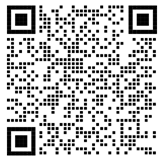

### (Optional) Example 1: Optimization bias

Consider a multiple-choice (a,b,c,d) "test" with 10 questions:
- If you choose answers randomly, expected grade is 25% (no bias).
- If you fill out two tests randomly and pick the best, expected grade is 33%.
    - Optimization bias of ~8%.
- If you take the best among 10 random tests, expected grade is ~47%.
- If you take the best among 100, expected grade is ~62%.
- If you take the best among 1000, expected grade is ~73%.
- If you take the best among 10000, expected grade is ~82%.
    - You have so many "chances" that you expect to do well.
    
**But on new questions the "random choice" accuracy is still 25%.**

In [64]:
# (Optional) Code attribution: Rodolfo Lourenzutti
number_tests = [1, 2, 10, 100, 1000, 10000]
for ntests in number_tests:
    y = np.zeros(10000)
    for i in range(10000):
        y[i] = np.max(np.random.binomial(10.0, 0.25, ntests))
    print(
        "The expected grade among the best of %d tests is : %0.2f"
        % (ntests, np.mean(y) / 10.0)
    )

The expected grade among the best of 1 tests is : 0.25
The expected grade among the best of 2 tests is : 0.33
The expected grade among the best of 10 tests is : 0.47
The expected grade among the best of 100 tests is : 0.62
The expected grade among the best of 1000 tests is : 0.73
The expected grade among the best of 10000 tests is : 0.83


### (Optional) Example 2: Optimization bias 

- If we instead used a 100-question test then:
    - Expected grade from best over 1 randomly-filled test is 25%.
    - Expected grade from best over 2 randomly-filled test is ~27%.
    - Expected grade from best over 10 randomly-filled test is ~32%.
    - Expected grade from best over 100 randomly-filled test is ~36%.
    - Expected grade from best over 1000 randomly-filled test is ~40%.
    - Expected grade from best over 10000 randomly-filled test is ~43%.
<br></br>

- The optimization bias **grows with the number of things we try** (in this example, the number of exam attempts; in ML, the number of models/hyperparameters combinations).
- But, optimization bias **shrinks quickly with the number of examples** (in this example, the number of questions in the exam; in ML, the number of samples).
    - But it’s still non-zero and growing if you over-use your validation set!    

In [65]:
# (Optional) Code attribution: Rodolfo Lourenzutti
number_tests = [1, 2, 10, 100, 1000, 10000]
for ntests in number_tests:
    y = np.zeros(10000)
    for i in range(10000):
        y[i] = np.max(np.random.binomial(100.0, 0.25, ntests))
    print(
        "The expected grade among the best of %d tests is : %0.2f"
        % (ntests, np.mean(y) / 100.0)
    )

The expected grade among the best of 1 tests is : 0.25
The expected grade among the best of 2 tests is : 0.27
The expected grade among the best of 10 tests is : 0.32
The expected grade among the best of 100 tests is : 0.36
The expected grade among the best of 1000 tests is : 0.40
The expected grade among the best of 10000 tests is : 0.43


### Optimization bias on the Spotify dataset

In [66]:
X_train_tiny, X_test_big, y_train_tiny, y_test_big = train_test_split(
    X_spotify, y_spotify, test_size=0.99, random_state=42
)

In [67]:
X_train_tiny.shape

(20, 14)

In [68]:
X_train_tiny.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title
130,0.055100,0.547,251093,0.643,0.000000,1,0.2670,-8.904,1,0.2270,143.064,4.0,0.1870,My Sub (Pt. 2: The Jackin') - Album Version (Edited)
1687,0.000353,0.420,210240,0.929,0.000747,7,0.1220,-3.899,0,0.1210,127.204,4.0,0.3180,Chop Suey!
871,0.314000,0.430,193427,0.734,0.000286,9,0.0808,-10.043,0,0.1020,133.992,4.0,0.0537,Able to See Me
1123,0.082100,0.725,246653,0.711,0.000000,10,0.0931,-4.544,1,0.0335,93.003,4.0,0.4760,Mi Tesoro (feat. Nicky Jam)
1396,0.286000,0.616,236960,0.387,0.000000,9,0.2770,-6.079,0,0.0335,81.856,4.0,0.4700,All in Vain


In [69]:
pipe = make_pipeline(preprocessor, SVC())

In [70]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "svc__gamma": 10.0 ** np.arange(-20, 10),
    "svc__C": 10.0 ** np.arange(-20, 10),
}
print("Grid size: %d" % (np.prod(list(map(len, param_grid.values())))))
param_grid

Grid size: 900


{'svc__gamma': array([1.e-20, 1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13,
        1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
        1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
        1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09]),
 'svc__C': array([1.e-20, 1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13,
        1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
        1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
        1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])}

In [71]:
random_search = RandomizedSearchCV(
    pipe, param_distributions=param_grid, n_jobs=-1, n_iter=900, cv=5, random_state=123
)
random_search.fit(X_train_tiny, y_train_tiny);

In [72]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,1,1,1,1,1,1,1,1,1,...,888,888,888,888,888,888,888,888,888,900
mean_test_score,6.500000e-01,0.65000,0.650000,0.650000,0.650000,0.650000,0.65000,0.650000,0.650000,0.650000,...,5.500000e-01,0.550000,0.550000,5.500000e-01,5.500000e-01,0.550000,5.500000e-01,0.550000,5.500000e-01,5.000000e-01
param_svc__gamma,1.000000e-20,0.00100,0.010000,0.100000,1.000000,10.000000,100.00000,1000.000000,10000.000000,100000.000000,...,1.000000e-01,0.100000,0.100000,1.000000e-10,1.000000e-01,0.100000,1.000000e-01,0.100000,1.000000e-09,1.000000e-09
param_svc__C,1.000000e-01,0.01000,0.010000,0.010000,0.010000,0.010000,0.01000,0.010000,0.010000,0.010000,...,1.000000e+07,1000.000000,1.000000,1.000000e+09,1.000000e+09,1000000.000000,1.000000e+08,10.000000,1.000000e+09,1.000000e+08
mean_fit_time,2.597599e-02,0.01849,0.020245,0.018677,0.016869,0.020736,0.01876,0.019918,0.019325,0.020585,...,2.096705e-02,0.017495,0.020624,2.131433e-02,2.051158e-02,0.023209,1.884661e-02,0.029271,1.954165e-02,2.225275e-02


Given the results: one might claim that we found a model that performs with 0.65 accuracy on our dataset. 

- Do we really **believe that 0.65 is a good estimate** of our test data?
- Do we really believe that `gamma`=0.0 and C=0.0 are the best hyperparameters? 

- Let's find out the **test score** with this best model. 

In [73]:
random_search.score(X_test, y_test)

0.5024752475247525

- The results above are **overly optimistic**. 
    - because our training data is very small and so our validation splits in cross validation would be small. 
    - because of the small dataset and the fact that we **hit the small validation set 900 times** and it's possible that we got lucky on the validation set! 

- As we suspected, the best cross-validation score is not a good estimate of our test data; it is overly optimistic. 
- We can trust this test score because the test set is of good size.

In [74]:
X_test_big.shape

(1997, 14)

### Overfitting of the validation data

The following plot demonstrates what happens during overfitting of the validation data.  
<center>
<img src='../img/optimization-bias.png' width="600">
</center>


[Source](https://amueller.github.io/COMS4995-s20/slides/aml-03-supervised-learning/#20)

- Thus, not only can we not trust the cv scores, we also cannot trust cv's ability to choose of the best hyperparameters. 


### Why do we need a test set? 
- This is why we need a test set.
- The frustrating part is that if our dataset is small then our test set is also small 😔. 
- But we don't have a lot of better alternatives, unfortunately, if we have a small dataset. 

### When test score is much lower than CV score
- What to do if your test score is much lower than your cross-validation score:
    - Try simpler models and **use the test set a couple of times**; it's not the end of the world.
    - **Communicate** this clearly when you report the results. 

### Large datasets solve many of these problems
- With infinite amounts of training data, overfitting would not be a problem and you could have your test score = your train score.
    - Overfitting happens because you only see a bit of data and you learn patterns that are overly specific to your sample.
    - If you saw "all" the data, then the notion of "overly specific" would not apply.
- So, more data will make your test score better and robust. 

## ❓❓ Questions for you

Attribution: From Mark Schmidt's notes

### Exercise 8.2

Would you trust the model?  

- You have a dataset and you give me 1/10th of it. The dataset given to me is rather small and so I split it into 96% train and 4% validation split. I carry out hyperparameter optimization using a single 4% validation split and report validation accuracy of 0.97. Would it classify the rest of the data with similar accuracy? 

1. Probably 
2. Probably not 

## Final comments and summary

#### Automated hyperparameter optimization

- Advantages 
    - reduce human effort
    - less prone to error and improve reproducibility
    - data-driven approaches may be effective
- Disadvantages
    - may be hard to incorporate intuition
    - be careful about overfitting on the validation set

Often, especially on typical datasets, we get back `scikit-learn`'s default hyperparameter values. This means that the defaults are well chosen by `scikit-learn` developers!

- The problem of finding the best values for the important hyperparameters is tricky because 
    - You may have a lot of them (e.g. deep learning). 
    - You may have multiple hyperparameters which may interact with each other in unexpected ways.    
- The best settings depend on the specific data/problem.

## Optional readings and resources

- [Preventing "overfitting" of cross-validation data](http://www.robotics.stanford.edu/~ang/papers/cv-final.pdf) by Andrew Ng

<br><br><br><br>

---
__Python Side Note__: *unpacking*

Let's use `best_parameters` as an example dictionary

In [75]:
best_parameters

{'C': 1, 'gamma': 0.1}

Example 1: unpacking a dictionary

In [76]:
{'A': 'abc', **best_parameters, 'D': 'def'}

{'A': 'abc', 'C': 1, 'gamma': 0.1, 'D': 'def'}

Example 2: unpacking a dictionary used as function arguments

In [77]:
def test1(C, gamma):
    print(f"C is {C} and gamma is {gamma}")

test1(**best_parameters)

C is 1 and gamma is 0.1


Example 3: unpacking using a single asterisk can be used for lists and tuples

In [78]:
[*best_parameters]

['C', 'gamma']

In [79]:
(*best_parameters,)  # note use of comma ',' here to enforce () be interpreted as a tuple

('C', 'gamma')

In [80]:
(*best_parameters, 'Something else', 5)  # last comma is not required anymore (but still optional)

('C', 'gamma', 'Something else', 5)

These single and double asterisks operators can be used in function definitions too

In [81]:
def test2(*args, **kwargs):
    print("Positional arguments:", args, "which also can be unpacked:", *args)
    print("Keyword arguments:", kwargs)  # but cannot unpack here as **kwargs; why? Give it a try!

test2(11, 123, a_kw_param=456, **best_parameters, another_kw_param=789)

Positional arguments: (11, 123) which also can be unpacked: 11 123
Keyword arguments: {'a_kw_param': 456, 'C': 1, 'gamma': 0.1, 'another_kw_param': 789}


__Python Side Note End__

---